<a href="https://colab.research.google.com/github/raghavthind2005/HealthApp/blob/main/DataPreperation_EY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install geopandas
!pip install shapely
!pip install pysheds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.6 MB/s eta 0:00:00


In [2]:
!pip install pandas

In [3]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 7.4 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Find Upstream River Flow Region

In [ ]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
from pysheds.grid import Grid
from shapely.geometry import Polygon, MultiPolygon, shape
import os

def get_connected_river(lat, lon, drive_dem_path, buffer_deg=1.5): # Increased buffer to 1.5 to capture more upstream
    """
    Finds ONLY the river channel that flows INTO the specific point.
    """
    min_lon, min_lat = lon - buffer_deg, lat - buffer_deg
    max_lon, max_lat = lon + buffer_deg, lat + buffer_deg
    chunk_filename = "/content/temp_connected_river.tif"

    try:
        with rasterio.open(drive_dem_path) as src:
            window = from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform)
            data = src.read(1, window=window)
            new_meta = src.meta.copy()
            new_meta.update({
                "driver": "GTiff", "height": data.shape[0],
                "width": data.shape[1], "transform": src.window_transform(window)
            })
            with rasterio.open(chunk_filename, "w", **new_meta) as dest:
                dest.write(data, 1)

    except Exception as e:
        return None

    print("No exception, onto flow logic")
    grid = Grid.from_raster(chunk_filename)
    dem = grid.read_raster(chunk_filename)

    pit_filled = grid.fill_pits(dem)
    flooded = grid.fill_depressions(pit_filled)
    inflated = grid.resolve_flats(flooded)

    dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    fdir = grid.flowdir(inflated, dirmap=dirmap)
    acc = grid.accumulation(fdir, dirmap=dirmap)

    # Find our specific river
    # look for a cell with high flow (>1000) near GPS
    x, y = lon, lat
    try:
        x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))
    except ValueError:
        print("Could not find a river near the point.")
        return None

    # GET THE CONNECTIVITY MASK
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')
    grid.clip_to(catch)
    catch_view = grid.view(catch, dtype=np.uint8) # 1 if connected, 0 if not

    # GET THE RIVER MASK
    # Threshold 5000 = Only big rivers.
    acc_view = grid.view(acc)
    river_mask = (acc_view > 5000).astype(np.uint8) # 1 if river, 0 if land

    # 6. THE INTERSECTION (Logic: AND)
    # We multiply them. 1 * 1 = 1.  1 * 0 = 0.
    final_mask = catch_view * river_mask

    # VECTORIZE
    shapes = grid.polygonize(final_mask)

    river_segments = []
    for s, value in shapes:
        if value > 0: # If it's a kept pixel
            river_segments.append(shape(s))

    if not river_segments:
        print("No upstream river found after filtering.")
        return None

    combined_river = MultiPolygon([p for p in river_segments if p.geom_type == 'Polygon'])

    # control the width. 0.01 = 1 KM radius
    return combined_river.buffer(0.005)

# RUN IT
drive_path = "/content/drive/MyDrive/evaluation.tif"
my_lat = -28.760833
my_lon = 17.730278

# buffer_deg controls the area of the box... 1.5 = 150 KM upstream
final_snake = get_connected_river(my_lat, my_lon, drive_path, buffer_deg=1.5)

if final_snake:
    gdf = gpd.GeoDataFrame(index=[0], geometry=[final_snake], crs="EPSG:4326")
    output_path = "/content/drive/MyDrive/river_body.geojson"
    gdf.to_file(output_path, driver="GeoJSON")
    print(f"✅ Success! Saved ONLY the connected river to {output_path}")

    # VISUALIZE
    import folium
    m = gdf.explore(color="red", style_kwds={"weight": 4}) # Red line for visibility
    folium.Marker([my_lat, my_lon], popup="My Point").add_to(m)
    display(m)

No exception, onto flow logic


✅ Success! Saved ONLY the connected river to /content/drive/MyDrive/river_body.geojson


# Hexagon Binning for Label Visualization

In [ ]:
# 1. Install the Hexagon Library (Only needs to run once)
!pip install h3

import pandas as pd
import folium
import h3
import branca.colormap as cm
from IPython.display import display
import json

# 2. Load Data
file_path = 'EY_CH_Dataset_csv.csv'
try:
    df = pd.read_csv(file_path, header=1)
except:
    df = pd.read_csv('/content/drive/MyDrive/EY_CH_Dataset_csv.csv', header=1)

# 3. Clean Data
df.columns = ['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']
parameters = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

# 4. HEXAGON SETTINGS
HEX_RESOLUTION = 5  # Size of hexagons (4 = ~22km, 5 = ~8.5km, 6 = ~3km). Adjust this for finer/coarser grids!

# Helper function to get hexagon geometry
def get_hex_geometry(hex_id):
    # Get the vertices of the hexagon
    # Note: h3 returns (lat, lon), Folium expects (lat, lon)
    try:
        # Try v3 syntax
        boundary = h3.h3_to_geo_boundary(hex_id)
    except AttributeError:
        # Fallback to v4 syntax
        boundary = h3.cell_to_boundary(hex_id)

    # Close the loop for GeoJSON (append first point to end)
    boundary = list(boundary)
    boundary.append(boundary[0])

    # GeoJSON expects [Longitude, Latitude] (reversed from h3/folium)
    geojson_coords = [[lon, lat] for lat, lon in boundary]

    return {
        "type": "Polygon",
        "coordinates": [geojson_coords]
    }

for param in parameters:
    print(f"Processing Hexbins for: {param}...")

    # Clean numeric data
    df[param] = pd.to_numeric(df[param], errors='coerce')
    subset = df.dropna(subset=['Latitude', 'Longitude', param]).copy()

    # --- Step A: Assign every point to a Hexagon ---
    try:
        # v3 syntax
        subset['hex_id'] = subset.apply(lambda row: h3.geo_to_h3(row['Latitude'], row['Longitude'], HEX_RESOLUTION), axis=1)
    except AttributeError:
        # v4 syntax
        subset['hex_id'] = subset.apply(lambda row: h3.latlng_to_cell(row['Latitude'], row['Longitude'], HEX_RESOLUTION), axis=1)

    # --- Step B: Aggregate Data (Calculate Average per Hexagon) ---
    hex_data = subset.groupby('hex_id')[param].mean().reset_index()

    # --- Step C: Setup Color Scale ---
    min_val = hex_data[param].min()
    max_val = hex_data[param].max()

    colormap = cm.LinearColormap(
        colors=['blue', 'cyan', 'yellow', 'red'],
        vmin=min_val,
        vmax=max_val,
        caption=f'Average {param}'
    )

    # --- Step D: Create Map ---
    center_lat = subset['Latitude'].mean()
    center_lon = subset['Longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6, tiles='CartoDB positron')

    # --- Step E: Add Hexagons to Map ---
    # We iterate through our aggregated data and draw a polygon for each hex
    for _, row in hex_data.iterrows():
        hex_id = row['hex_id']
        value = row[param]

        # Get color for this value
        color = colormap(value)

        try:
            boundary = h3.h3_to_geo_boundary(hex_id) # v3
        except AttributeError:
            boundary = h3.cell_to_boundary(hex_id)   # v4

        folium.Polygon(
            locations=boundary, # Folium wants [Lat, Lon]
            color=color,        # Border color
            weight=1,
            fill=True,
            fill_color=color,   # Fill color
            fill_opacity=0.6,
            popup=f"Hex: {hex_id}<br>Avg {param}: {value:.2f}"
        ).add_to(m)

    # Add Legend and Title
    m.add_child(colormap)
    title_html = f'<h3 align="center" style="font-size:16px"><b>{param} (Hexbin Aggregation)</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))

    display(m)
    m.save(f"{param.replace(' ', '_')}_Hexbin.html")
    print(f"✅ Saved Hexbin Map for {param}\n")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.9 MB/s eta 0:00:00
Processing Hexbins for: Total Alkalinity...


✅ Saved Hexbin Map for Total Alkalinity

Processing Hexbins for: Electrical Conductance...


✅ Saved Hexbin Map for Electrical Conductance

Processing Hexbins for: Dissolved Reactive Phosphorus...


✅ Saved Hexbin Map for Dissolved Reactive Phosphorus



# Training Data Preperation

In [5]:
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/training.csv')

In [6]:
train_df.head()

latitude  longitude        date      blue     green       red       nir  \
0 -28.760833  17.730278  02-01-2011  0.071191  0.114197  0.156956  0.111319   
1 -26.861111  28.884722  03-01-2011  0.039639  0.064119  0.053877  0.319675   
2 -26.450000  28.085833  03-01-2011  0.084759  0.098489  0.082719  0.310668   
3 -27.671111  27.236944  03-01-2011  0.097687  0.122437  0.118642  0.285237   
4 -27.356667  27.286389  03-01-2011  0.053481  0.076917  0.068101  0.298056   

     swir16    swir22      ndvi  ...  pdsi  phosphorus_extractable  precip_mm  \
0  0.010391  0.007080 -0.170111  ... -1.16                9.087652          8   
1  0.172265  0.084941  0.711541  ...  1.57                6.800183        175   
2  0.195647  0.097118  0.579451  ... -0.62                7.373092        156   
3  0.184257  0.134978  0.412485  ...  3.07                8.223428        195   
4  0.193996  0.096705  0.628023  ...  2.69                6.264912        182   

   sanlc_id  soil_moisture_mm   soil_ph  srad_Wm2  tmax_C  tmin_C  vap_kPa  
0        31               0.0  7.770436     317.5    35.8    21.0    1.384  
1        13              36.8  6.502003     240.6    25.4    14.1    1.633  
2        12              10.5  6.375087     245.3    26.1    15.3    1.638  
3        48              28.3  6.537874     250.6    27.5    15.8    1.585  
4        13              24.9  6.481087     251.6    27.2    16.0    1.616  

[5 rows x 21 columns]

In [7]:
train_df.columns

Index(['latitude', 'longitude', 'date', 'blue', 'green', 'red', 'nir',
       'swir16', 'swir22', 'ndvi', 'aet_mm', 'pdsi', 'phosphorus_extractable',
       'precip_mm', 'sanlc_id', 'soil_moisture_mm', 'soil_ph', 'srad_Wm2',
       'tmax_C', 'tmin_C', 'vap_kPa'],
      dtype='object')

# Soil Ph analysis + *preperation*

In [8]:
print(train_df['soil_ph'].describe())

count    9319.000000
mean        6.500383
std         0.413383
min         5.430409
25%         6.232471
50%         6.481087
75%         6.710589
max         7.934965
Name: soil_ph, dtype: float64


In [9]:
# Check for null values
null_count = train_df['soil_ph'].isnull().sum()
null_percent = (null_count / len(train_df)) * 100

print(f"Missing Values: {null_count}")
print(f"Percentage Missing: {null_percent:.2f}%")

Missing Values: 0
Percentage Missing: 0.00%


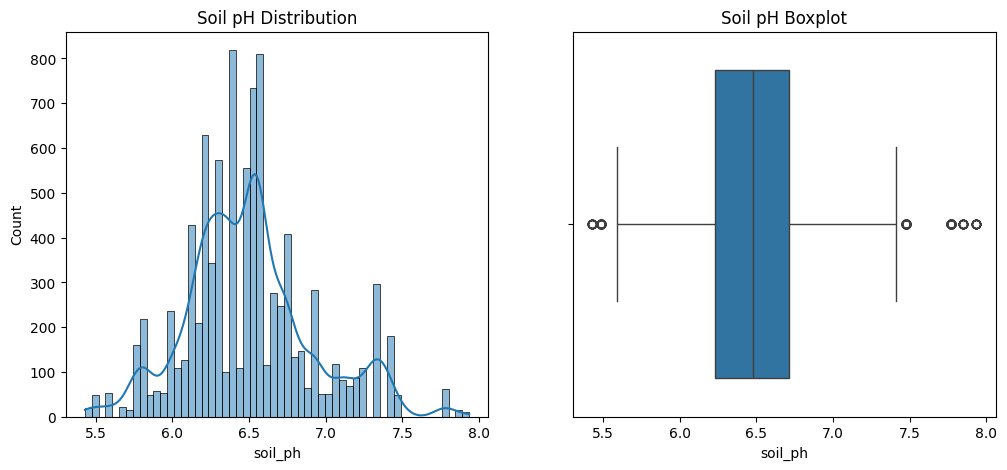

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram with Kernel Density Estimate
sns.histplot(train_df['soil_ph'], kde=True, ax=ax[0])
ax[0].set_title('Soil pH Distribution')

# Boxplot to see outliers
sns.boxplot(x=train_df['soil_ph'], ax=ax[1])
ax[1].set_title('Soil pH Boxplot')

plt.show()

Decisions & Notes:
 - There are 0 missing values.
 - The range (5.43 to 7.94) is perfectly within the natural bounds of soil pH.
 - Presence of a few outliers beyond thw whiskers, but we will keep them as they are well within natural range
 - Standard Normal Distribution
 - No steps require here

# Phosphorus

count    9319.000000
mean        8.919672
std         2.686312
min         5.058287
25%         6.664305
50%         8.362142
75%        11.072172
max        15.570875
Name: phosphorus_extractable, dtype: float64

Missing Values: 0


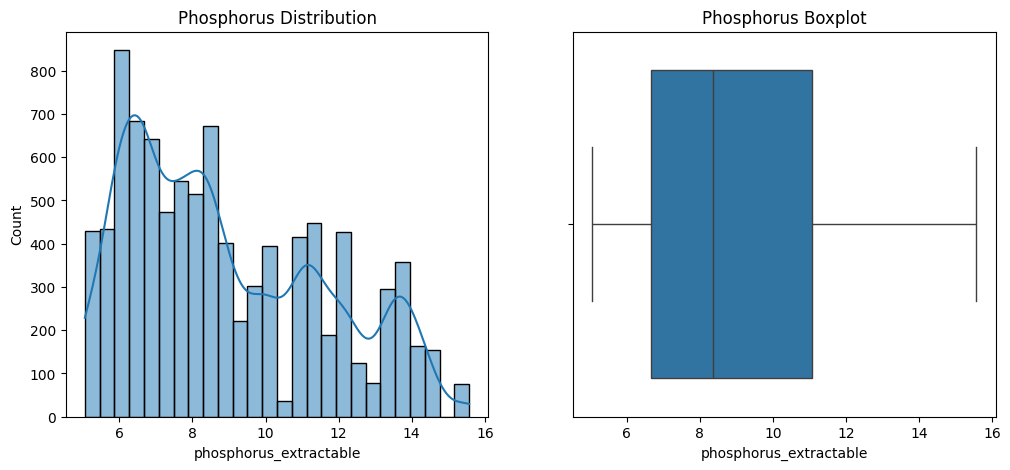

In [11]:
# 1. Descriptive stats to check for skew and range
print(train_df['phosphorus_extractable'].describe())

# 2. Null check
print("\nMissing Values:", train_df['phosphorus_extractable'].isnull().sum())

# 3. Visuals: Histogram for skewness and Boxplot for extreme outliers
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(train_df['phosphorus_extractable'], kde=True, ax=ax[0])
ax[0].set_title('Phosphorus Distribution')
sns.boxplot(x=train_df['phosphorus_extractable'], ax=ax[1])
ax[1].set_title('Phosphorus Boxplot')
plt.show()

Notes and Decisions:
- Data Integrity: 0 missing values
- The range is physically valid
- Distribution: Not a bell curve, Maybe multimodal, but not skewed enough to require log transformation right now
- No steps required

# sanlc_landcover: sanlc_id

Missing Values: 0
Data Type: int64

Number of Unique Land Cover Classes: 28

Value Counts for each Class ID (Top 15):
sanlc_id
13    2198
12    2004
4     1202
40     612
9      492
2      316
38     287
3      233
11     205
59     203
48     202
44     182
32     142
31     121
36     107
Name: count, dtype: int64


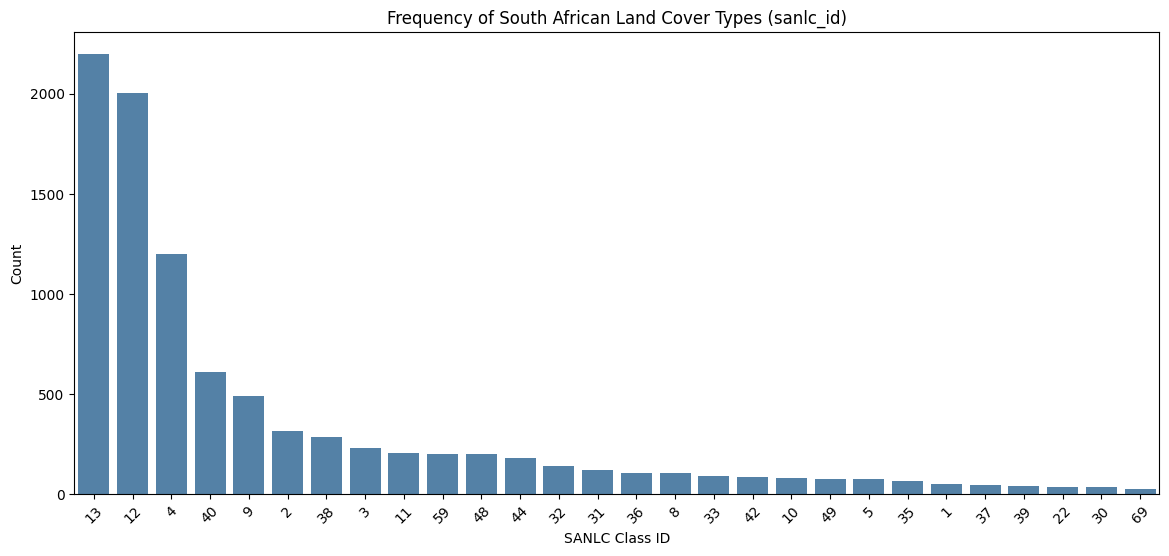

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Null check
print(f"Missing Values: {train_df['sanlc_id'].isnull().sum()}")

# 2. Check the data type (it's often good to cast these as 'category' or 'object' later)
print(f"Data Type: {train_df['sanlc_id'].dtype}")

# 3. Cardinality (How many unique land cover types exist in the training data?)
num_unique_classes = train_df['sanlc_id'].nunique()
print(f"\nNumber of Unique Land Cover Classes: {num_unique_classes}")

# 4. Frequency of each class (Top 15 to see if it's heavily imbalanced)
print("\nValue Counts for each Class ID (Top 15):")
print(train_df['sanlc_id'].value_counts().head(15))

# 5. Visualization: Countplot ordered by frequency
plt.figure(figsize=(14, 6))
sns.countplot(data=train_df, x='sanlc_id',
              order=train_df['sanlc_id'].value_counts().index,
              color='steelblue')
plt.title('Frequency of South African Land Cover Types (sanlc_id)')
plt.xlabel('SANLC Class ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [13]:
train_df['sanlc_id'].value_counts()

sanlc_id
13    2198
12    2004
4     1202
40     612
9      492
2      316
38     287
3      233
11     205
59     203
48     202
44     182
32     142
31     121
36     107
8      107
33      91
42      84
10      81
49      78
5       74
35      64
1       49
37      44
39      43
22      35
30      35
69      28
Name: count, dtype: int64

Decision:
-  one-hot encode sanlc_id since its a categorical data id variable

In [14]:
# 1. Convert to integer to drop any potential decimals, then to string
train_df['sanlc_id'] = train_df['sanlc_id'].astype(int).astype(str)

# 2. Perform One-Hot Encoding using pd.get_dummies
train_df_encoded = pd.get_dummies(train_df, columns=['sanlc_id'], prefix='sanlc')

# 3. Check our work
print(f"Original Train Shape: {train_df.shape}")
print(f"Encoded Train Shape: {train_df_encoded.shape}")

# Save the expected columns so we can enforce them on the validation set later
expected_columns = train_df_encoded.columns

Original Train Shape: (9319, 21)
Encoded Train Shape: (9319, 48)


# Date

In [15]:
# 1. Ensure we are using the updated dataframe variable
train_df = train_df_encoded.copy()

# 2. Parse the dates safely using the explicit Day-Month-Year format
train_df['date'] = pd.to_datetime(train_df['date'], format='%d-%m-%Y')

# 3. Extract numerical features for the tree model
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day_of_year'] = train_df['date'].dt.dayofyear

# Check our work (Notice 'date' is still there!)
print("Training Data Date Features:")
print(train_df[['date', 'year', 'month', 'day_of_year']].head())

Training Data Date Features:
        date  year  month  day_of_year
0 2011-01-02  2011      1            2
1 2011-01-03  2011      1            3
2 2011-01-03  2011      1            3
3 2011-01-03  2011      1            3
4 2011-01-03  2011      1            3


Remember to not put the "date column" itself in training data

# Water-climate

TRAINING DATA: Null Counts
precip_mm           0
aet_mm              0
pdsi                0
soil_moisture_mm    0
dtype: int64

TRAINING DATA: Descriptive Statistics
         precip_mm       aet_mm         pdsi  soil_moisture_mm
count  9319.000000  9319.000000  9319.000000       9319.000000
mean     41.959760    39.504797    -1.248812          8.220335
std      44.984014    37.637004     2.471602         13.823840
min       0.000000     0.000000    -6.330000          0.000000
25%       7.000000     8.400000    -2.940000          1.100000
50%      29.000000    29.700000    -2.040000          3.300000
75%      60.000000    58.300000    -0.400000          8.800000
max     374.000000   176.800000     8.160000        164.700000


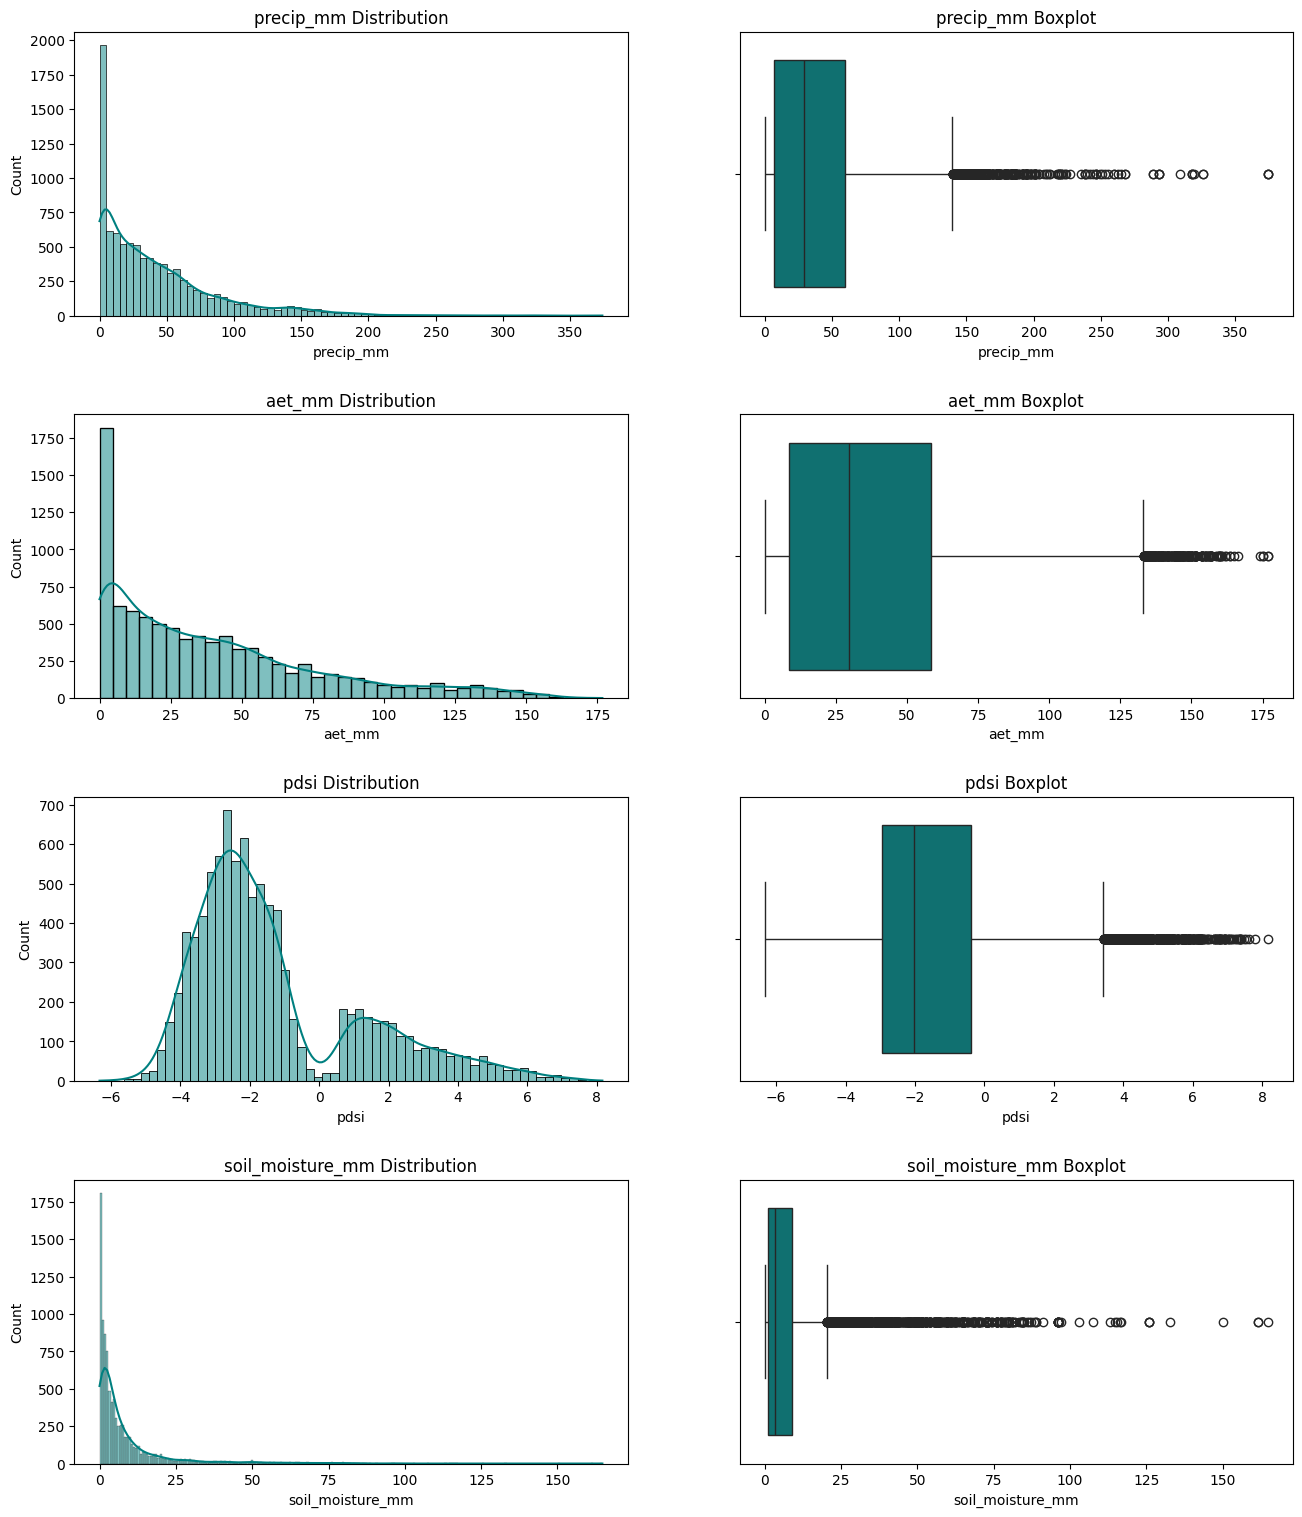

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

water_features = ['precip_mm', 'aet_mm', 'pdsi', 'soil_moisture_mm']

# 1. Null check & Basic Stats
print("TRAINING DATA: Null Counts")
print(train_df[water_features].isnull().sum())
print("\nTRAINING DATA: Descriptive Statistics")
print(train_df[water_features].describe())

# 2. Visualizations
fig, axes = plt.subplots(len(water_features), 2, figsize=(14, 16))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(water_features):
    # Histogram
    sns.histplot(train_df[feature], kde=True, ax=axes[i, 0], color='teal')
    axes[i, 0].set_title(f'{feature} Distribution')

    # Boxplot
    sns.boxplot(x=train_df[feature], ax=axes[i, 1], color='teal')
    axes[i, 1].set_title(f'{feature} Boxplot')

plt.show()

Outliers and 0 skewing not a problem for tree models.
- MIGHT NEED TO ENGINEER A LAG FEATURE
the water data of today wouldnt affect the water quality parameters of today, compared to the last 7 days...

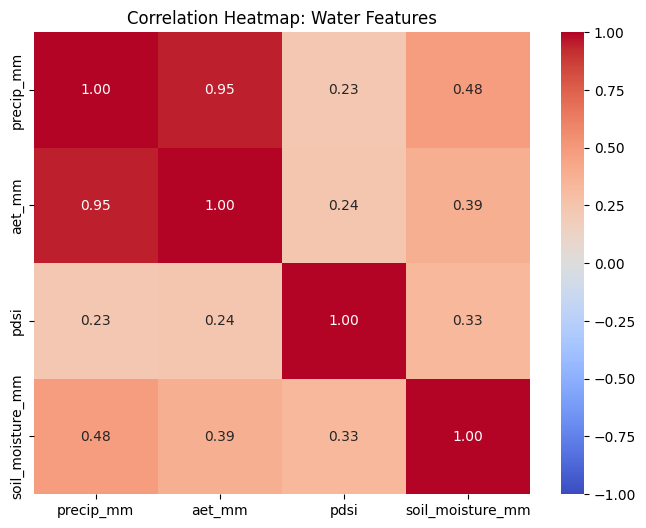

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the features again just to be safe
water_features = ['precip_mm', 'aet_mm', 'pdsi', 'soil_moisture_mm']

# Calculate the Pearson correlation matrix
corr_matrix = train_df[water_features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap: Water Features")
plt.show()

# climate variable clusters: tmax_C', 'tmin_C', 'srad_Wm2', 'vap_kPa




TRAINING DATA: Null Counts
tmax_C      0
tmin_C      0
srad_Wm2    0
vap_kPa     0
dtype: int64

TRAINING DATA: Descriptive Statistics
            tmax_C       tmin_C     srad_Wm2      vap_kPa
count  9319.000000  9319.000000  9319.000000  9319.000000
mean     26.042547    10.382981   221.276392     1.265951
std       4.378606     5.606075    55.201235     0.455403
min      11.500000    -4.200000   100.900000     0.496000
25%      23.000000     6.200000   174.800000     0.879500
50%      26.500000    11.100000   219.600000     1.238000
75%      29.200000    14.800000   265.350000     1.599000
max      37.600000    23.000000   345.600000     2.711000


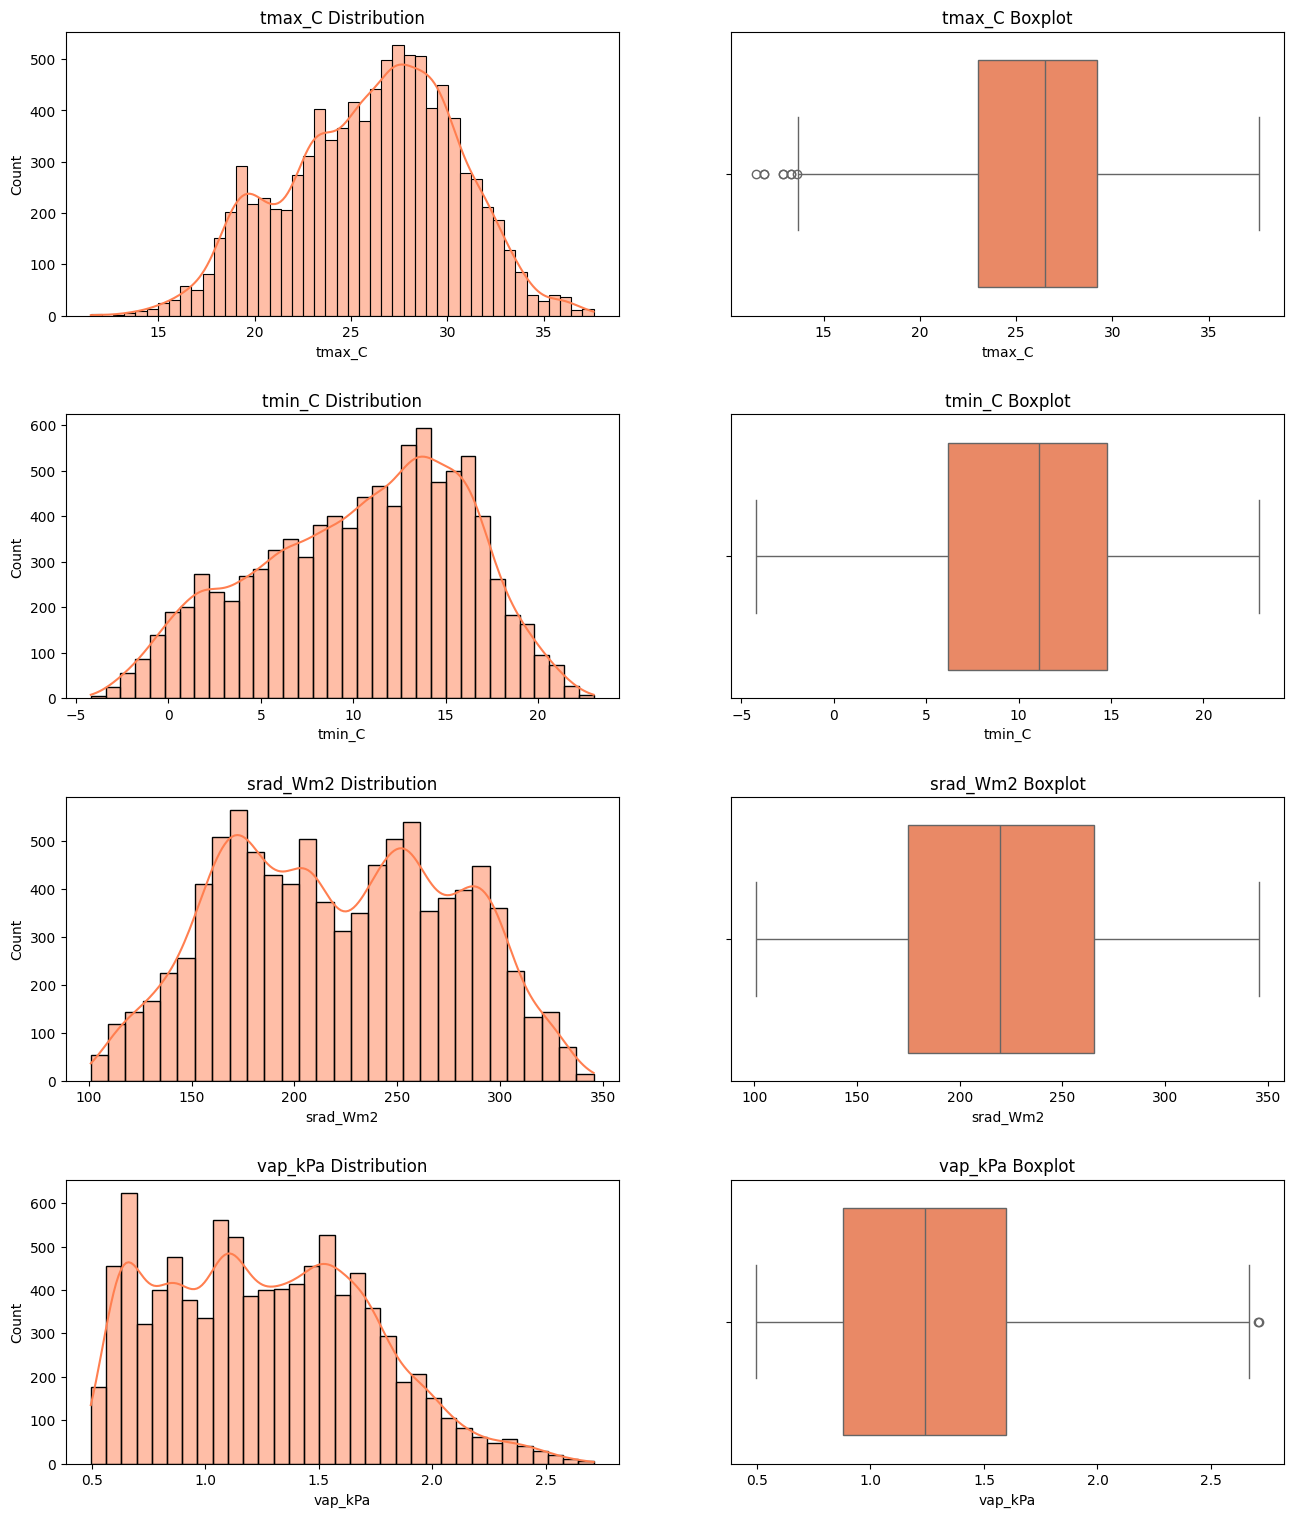


Physics Anomalies (tmin > tmax): 0 rows


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

climate_features = ['tmax_C', 'tmin_C', 'srad_Wm2', 'vap_kPa']

# 1. Null check & Basic Stats
print("TRAINING DATA: Null Counts")
print(train_df[climate_features].isnull().sum())
print("\nTRAINING DATA: Descriptive Statistics")
print(train_df[climate_features].describe())

# 2. Visualizations
fig, axes = plt.subplots(len(climate_features), 2, figsize=(14, 16))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(climate_features):
    # Histogram
    sns.histplot(train_df[feature], kde=True, ax=axes[i, 0], color='coral')
    axes[i, 0].set_title(f'{feature} Distribution')

    # Boxplot
    sns.boxplot(x=train_df[feature], ax=axes[i, 1], color='coral')
    axes[i, 1].set_title(f'{feature} Boxplot')

plt.show()

# 3. Physics Check: Are there any rows where minimum temp is higher than maximum temp?
anomalies = train_df[train_df['tmin_C'] > train_df['tmax_C']]
print(f"\nPhysics Anomalies (tmin > tmax): {len(anomalies)} rows")

# satellite_features = ['ndvi', 'blue', 'green', 'red', 'nir', 'swir16', 'swir22']

TRAINING DATA: Null Counts
ndvi      83
blue      83
green     83
red       83
nir       83
swir16    83
swir22    83
dtype: int64

TRAINING DATA: Descriptive Statistics
              ndvi         blue        green          red          nir  \
count  9236.000000  9236.000000  9236.000000  9236.000000  9236.000000   
mean      0.399840     0.046302     0.074330     0.084927     0.201504   
std       0.155012     0.015480     0.018129     0.026611     0.050073   
min      -0.266681     0.008129     0.015316     0.009566     0.058330   
25%       0.286828     0.036745     0.063250     0.066406     0.173279   
50%       0.390303     0.045321     0.073169     0.083415     0.202331   
75%       0.507714     0.054258     0.084446     0.101241     0.232193   
max       0.872256     0.441317     0.461272     0.449448     0.456650   

            swir16       swir22  
count  9236.000000  9236.000000  
mean      0.189995     0.127514  
std       0.057755     0.046424  
min       0.010391     0.00

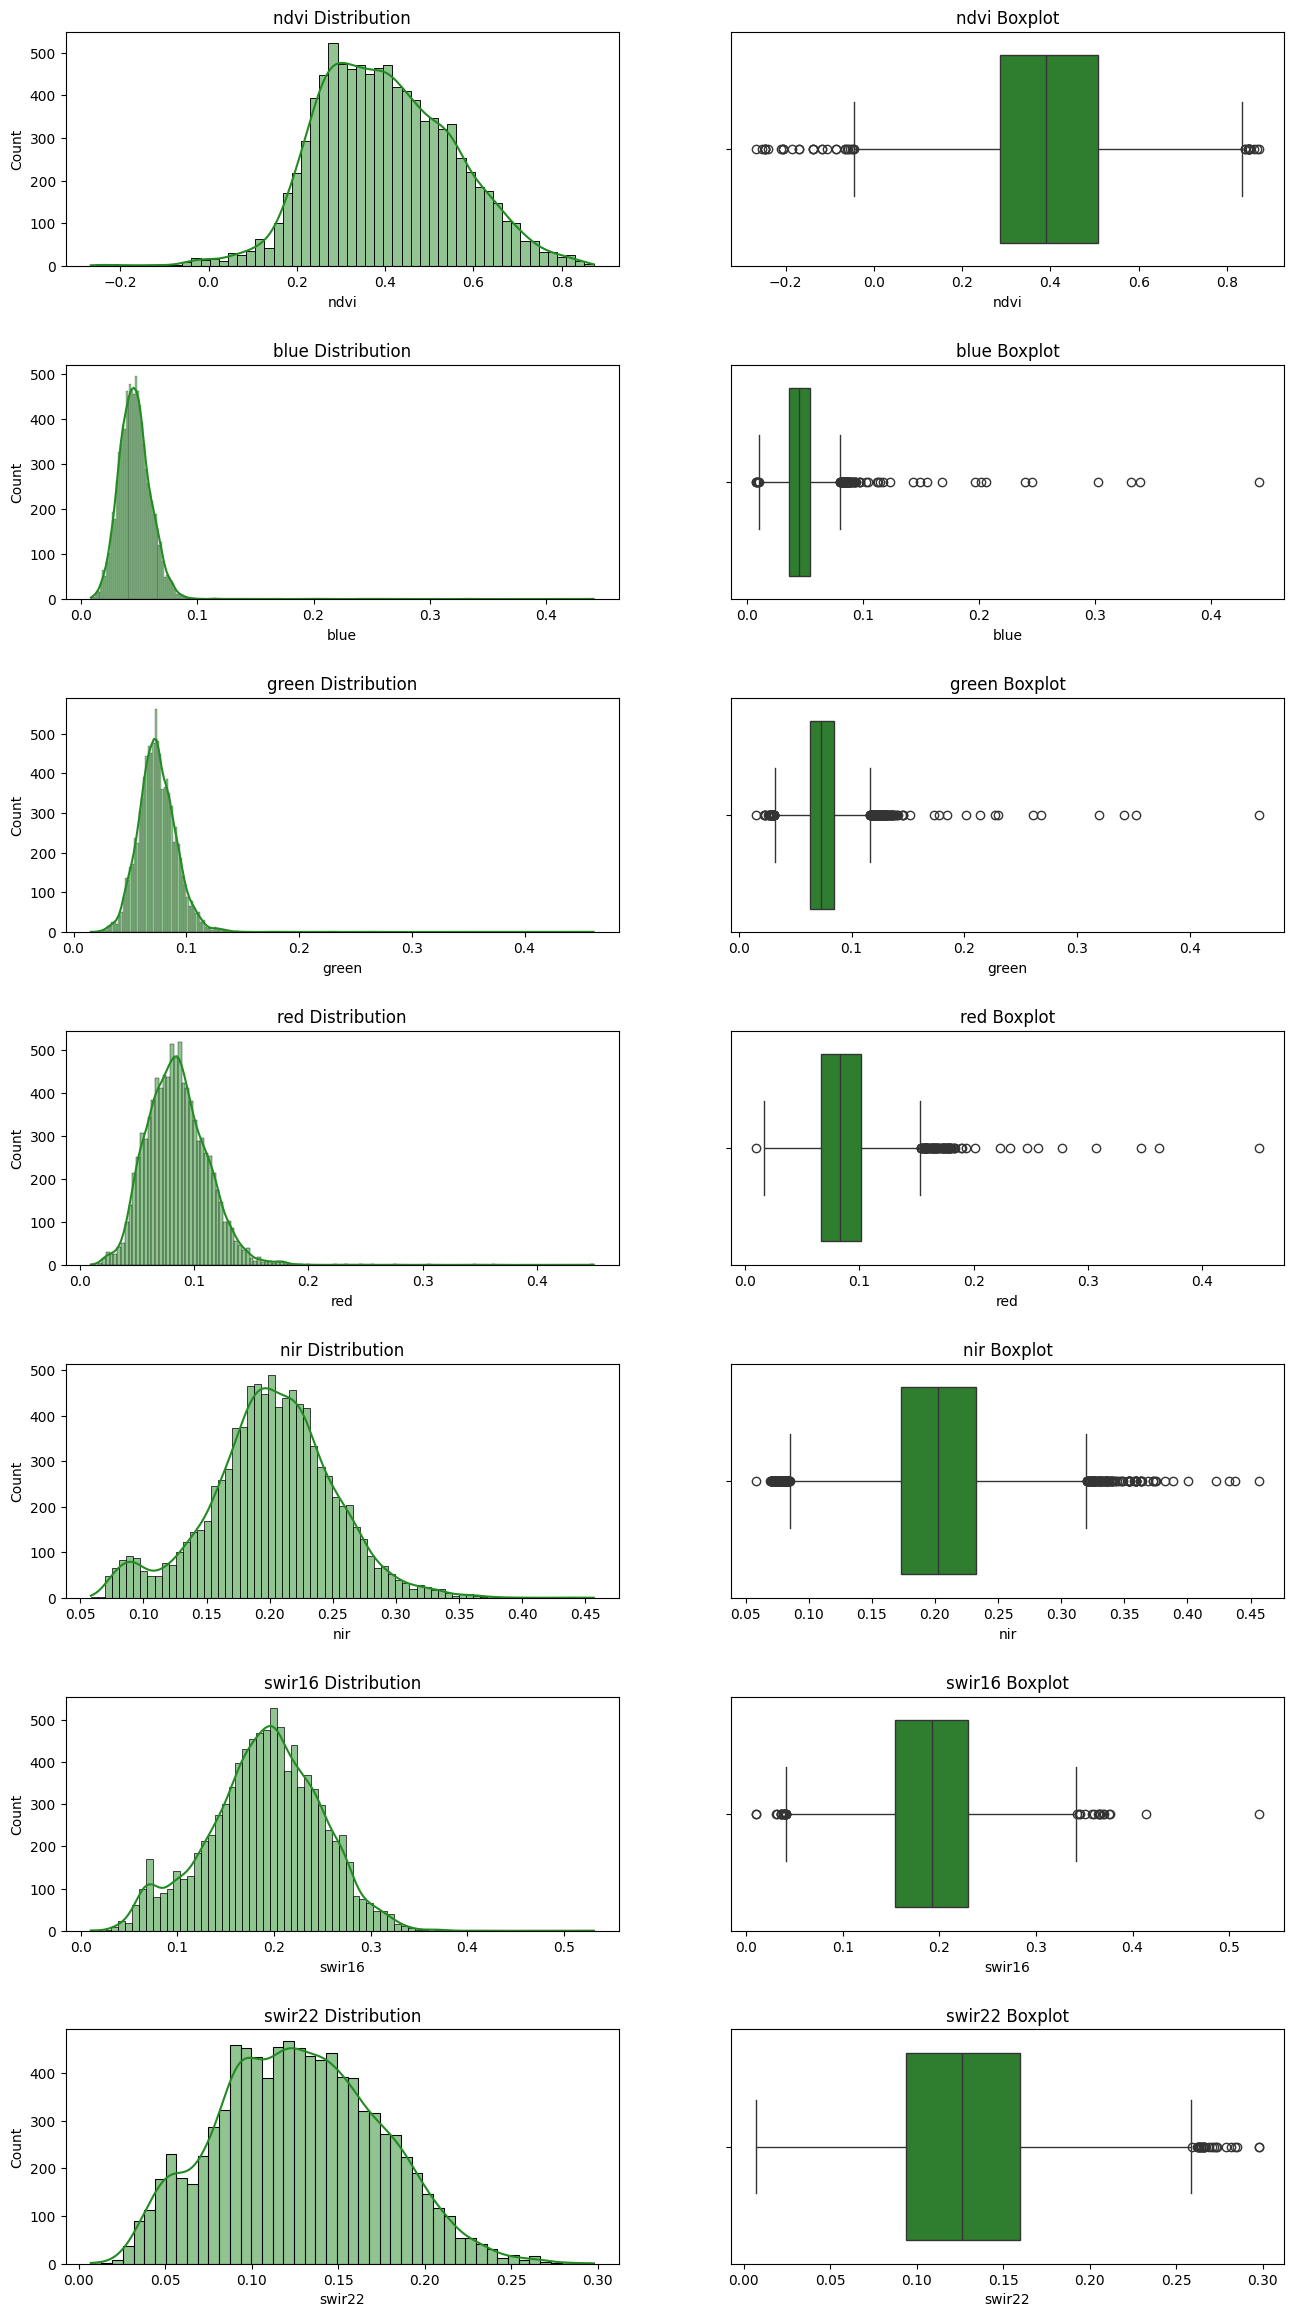


Physics Anomalies (NDVI outside -1 to 1): 0 rows
Physics Anomalies (Negative Reflectance Bands): 0 rows


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

satellite_features = ['ndvi', 'blue', 'green', 'red', 'nir', 'swir16', 'swir22']

# 1. Null check & Basic Stats
print("TRAINING DATA: Null Counts")
print(train_df[satellite_features].isnull().sum())
print("\nTRAINING DATA: Descriptive Statistics")
print(train_df[satellite_features].describe())

# 2. Visualizations
fig, axes = plt.subplots(len(satellite_features), 2, figsize=(14, 24))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(satellite_features):
    # Histogram
    sns.histplot(train_df[feature], kde=True, ax=axes[i, 0], color='forestgreen')
    axes[i, 0].set_title(f'{feature} Distribution')

    # Boxplot
    sns.boxplot(x=train_df[feature], ax=axes[i, 1], color='forestgreen')
    axes[i, 1].set_title(f'{feature} Boxplot')

plt.show()

# 3. Physics Checks
out_of_bounds_ndvi = train_df[(train_df['ndvi'] < -1) | (train_df['ndvi'] > 1)]
print(f"\nPhysics Anomalies (NDVI outside -1 to 1): {len(out_of_bounds_ndvi)} rows")

negative_bands = train_df[(train_df[['blue', 'green', 'red', 'nir', 'swir16', 'swir22']] < 0).any(axis=1)]
print(f"Physics Anomalies (Negative Reflectance Bands): {len(negative_bands)} rows")

In [20]:
import numpy as np

# 1. Explicitly ensure any missing values are standard numpy NaNs
# (This prevents XGBoost/LightGBM from tripping over string 'None' or 'NA')
train_df[satellite_features] = train_df[satellite_features].fillna(value=np.nan)

# 2. Verify we kept all 9319 rows and still have the NaNs
print(f"Train Shape: {train_df.shape} (No rows dropped!)")
print("Train NaNs preserved for Native Handling:")
print(train_df[satellite_features].isnull().sum())

Train Shape: (9319, 51) (No rows dropped!)
Train NaNs preserved for Native Handling:
ndvi      83
blue      83
green     83
red       83
nir       83
swir16    83
swir22    83
dtype: int64


# Verifying label distribution

In [21]:
train_df.columns

Index(['latitude', 'longitude', 'date', 'blue', 'green', 'red', 'nir',
       'swir16', 'swir22', 'ndvi', 'aet_mm', 'pdsi', 'phosphorus_extractable',
       'precip_mm', 'soil_moisture_mm', 'soil_ph', 'srad_Wm2', 'tmax_C',
       'tmin_C', 'vap_kPa', 'sanlc_1', 'sanlc_10', 'sanlc_11', 'sanlc_12',
       'sanlc_13', 'sanlc_2', 'sanlc_22', 'sanlc_3', 'sanlc_30', 'sanlc_31',
       'sanlc_32', 'sanlc_33', 'sanlc_35', 'sanlc_36', 'sanlc_37', 'sanlc_38',
       'sanlc_39', 'sanlc_4', 'sanlc_40', 'sanlc_42', 'sanlc_44', 'sanlc_48',
       'sanlc_49', 'sanlc_5', 'sanlc_59', 'sanlc_69', 'sanlc_8', 'sanlc_9',
       'year', 'month', 'day_of_year'],
      dtype='object')

In [22]:
labels_df = pd.read_csv('/content/drive/MyDrive/EY_CH_Dataset_csv.csv', header = 1)

In [23]:
labels_df.columns

Index(['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity',
       'Electrical Conductance', 'Dissolved Reactive Phosphorus'],
      dtype='object')

In [24]:
import pandas as pd
import numpy as np

# 1. Reset our dataframes to ensure we are starting fresh before the failed merge
# (Assuming you still have your un-merged train_df and original labels_df in memory)
# If labels_df is freshly loaded, ensure it is named correctly:
if 'Sample Date' in labels_df.columns:
    labels_df = labels_df.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude', 'Sample Date': 'date'})

# 2. Inspect original shapes to ensure labels_df actually has ~9300 rows
print(f"Pre-Merge train_df shape:  {train_df.shape}")
print(f"Pre-Merge labels_df shape: {labels_df.shape}")

# 3. Bulletproof the Dates (Strip any hidden hours/minutes/seconds)
# Ensure both are datetime objects, then normalize them to midnight
if not np.issubdtype(labels_df['date'].dtype, np.datetime64):
    # Adjust format if your labels_df date format is actually YYYY-MM-DD
    labels_df['date'] = pd.to_datetime(labels_df['date'], format='%d-%m-%Y', errors='coerce')

train_df['date'] = train_df['date'].dt.normalize()
labels_df['date'] = labels_df['date'].dt.normalize()

# 4. Bulletproof the Coordinates (Round to 5 decimal places to kill float artifacts)
train_df['latitude'] = train_df['latitude'].round(5)
train_df['longitude'] = train_df['longitude'].round(5)
labels_df['latitude'] = labels_df['latitude'].round(5)
labels_df['longitude'] = labels_df['longitude'].round(5)

# 5. Diagnostic: Check how many keys ACTUALLY match now
lat_match = train_df['latitude'].isin(labels_df['latitude']).sum()
lon_match = train_df['longitude'].isin(labels_df['longitude']).sum()
date_match = train_df['date'].isin(labels_df['date']).sum()

print(f"\nDiagnostics (Out of {len(train_df)} train rows):")
print(f"- Latitudes matching:  {lat_match}")
print(f"- Longitudes matching: {lon_match}")
print(f"- Dates matching:      {date_match}")

# 6. The Bulletproof Merge
merged_train_df = pd.merge(
    train_df,
    labels_df[['latitude', 'longitude', 'date', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']],
    on=['latitude', 'longitude', 'date'],
    how='inner'
)

print(f"\nFinal Merged Train Shape: {merged_train_df.shape}")

# If successful, overwrite train_df
if len(merged_train_df) > 4500:
    train_df = merged_train_df.copy()

Pre-Merge train_df shape:  (9319, 51)
Pre-Merge labels_df shape: (9319, 6)

Diagnostics (Out of 9319 train rows):
- Latitudes matching:  9319
- Longitudes matching: 9319
- Dates matching:      9319

Final Merged Train Shape: (9319, 54)


Missing Labels in Training Data:
Total Alkalinity                 0
Electrical Conductance           0
Dissolved Reactive Phosphorus    0
dtype: int64

Target Variables Summary Statistics:
       Total Alkalinity  Electrical Conductance  Dissolved Reactive Phosphorus
count       9319.000000             9319.000000                    9319.000000
mean         119.108208              485.004146                      43.525338
std           74.692591              341.937736                      50.980194
min            4.800000               15.120000                       5.000000
25%           55.811000              207.050000                      10.000000
50%          113.300000              402.000000                      20.000000
75%          170.230000              693.000000                      48.000000
max          361.676000             1506.000000                     195.000000


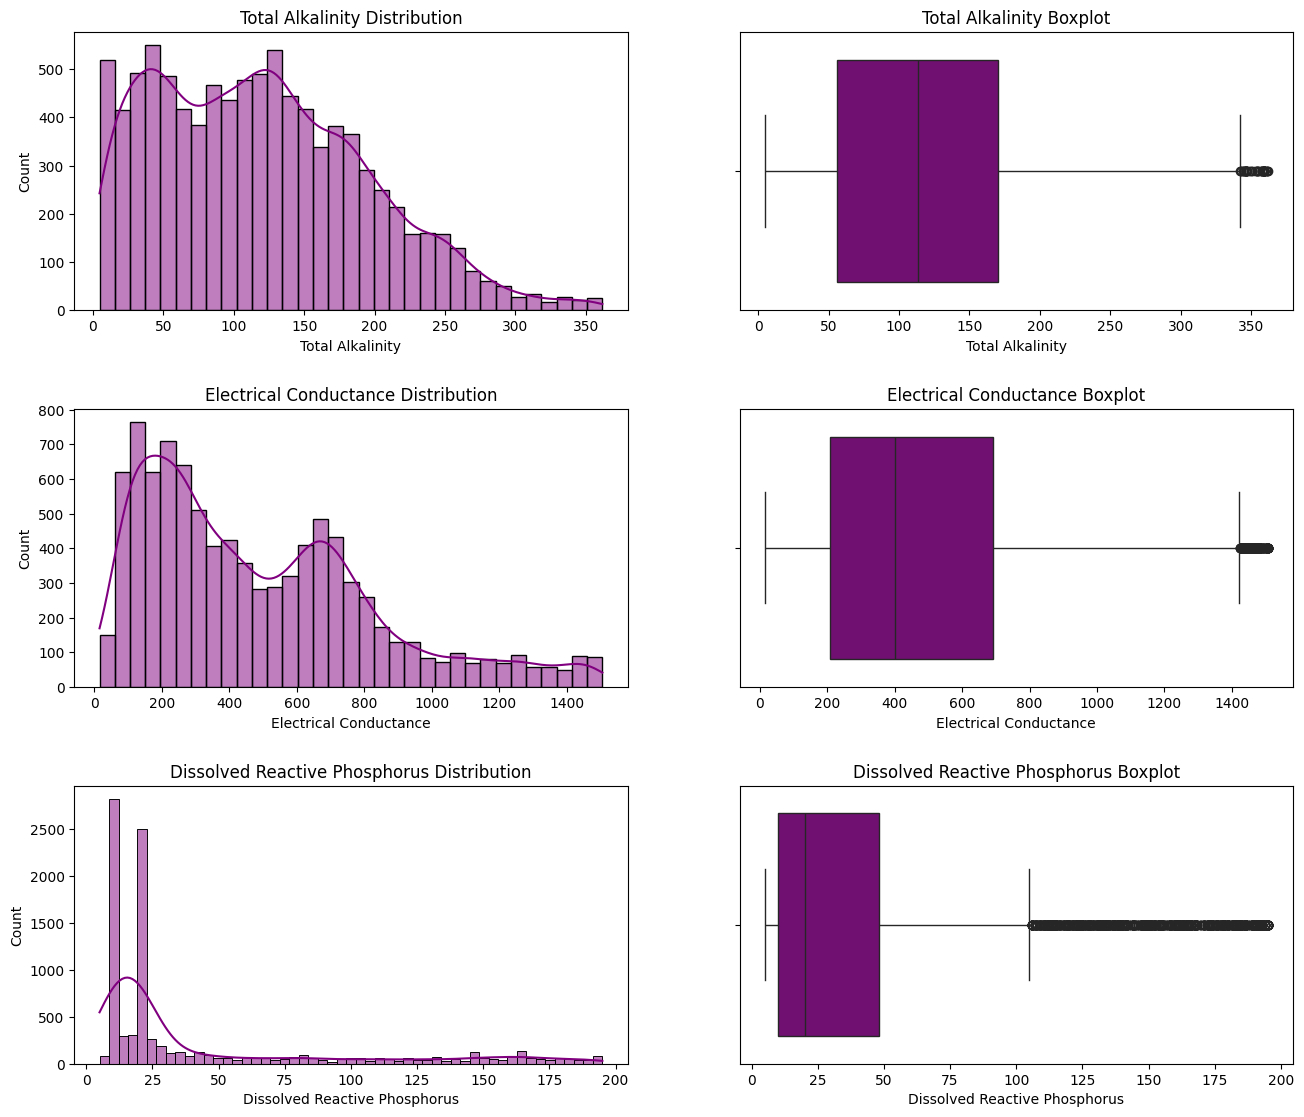

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

target_cols = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

# 1. Null Check (Did the lab lose any samples?)
print("Missing Labels in Training Data:")
print(train_df[target_cols].isnull().sum())

# 2. Descriptive Statistics
print("\nTarget Variables Summary Statistics:")
print(train_df[target_cols].describe())

# 3. Visualizations (Hunting for extreme skewness)
fig, axes = plt.subplots(len(target_cols), 2, figsize=(14, 12))
fig.tight_layout(pad=5.0)

for i, target in enumerate(target_cols):
    # Histogram
    sns.histplot(train_df[target], kde=True, ax=axes[i, 0], color='purple')
    axes[i, 0].set_title(f'{target} Distribution')

    # Boxplot
    sns.boxplot(x=train_df[target], ax=axes[i, 1], color='purple')
    axes[i, 1].set_title(f'{target} Boxplot')

plt.show()

- apply np.log1p() and np.expm1() for dissolved reactive phosphorus
- leave alkalinity as it is
- electrical conductance might need it later


In [26]:
# Calculate exact skewness for the targets
skewness_scores = train_df[['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']].skew()

print("Mathematical Skewness Scores:")
print(skewness_scores)
print("\n(Rule of thumb: > 1.0 is highly skewed and strictly requires transformation)")

Mathematical Skewness Scores:
Total Alkalinity                 0.536229
Electrical Conductance           0.929458
Dissolved Reactive Phosphorus    1.644685
dtype: float64

(Rule of thumb: > 1.0 is highly skewed and strictly requires transformation)


In [27]:
train_df.columns

Index(['latitude', 'longitude', 'date', 'blue', 'green', 'red', 'nir',
       'swir16', 'swir22', 'ndvi', 'aet_mm', 'pdsi', 'phosphorus_extractable',
       'precip_mm', 'soil_moisture_mm', 'soil_ph', 'srad_Wm2', 'tmax_C',
       'tmin_C', 'vap_kPa', 'sanlc_1', 'sanlc_10', 'sanlc_11', 'sanlc_12',
       'sanlc_13', 'sanlc_2', 'sanlc_22', 'sanlc_3', 'sanlc_30', 'sanlc_31',
       'sanlc_32', 'sanlc_33', 'sanlc_35', 'sanlc_36', 'sanlc_37', 'sanlc_38',
       'sanlc_39', 'sanlc_4', 'sanlc_40', 'sanlc_42', 'sanlc_44', 'sanlc_48',
       'sanlc_49', 'sanlc_5', 'sanlc_59', 'sanlc_69', 'sanlc_8', 'sanlc_9',
       'year', 'month', 'day_of_year', 'Total Alkalinity',
       'Electrical Conductance', 'Dissolved Reactive Phosphorus'],
      dtype='object')

# Training

# total alkalinity

## Baseline & Feature Importance
(use all features)

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# 1. Define the full feature list
exclude_cols = ['date', 'year','longitude','latitude','Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']
features = [col for col in train_df.columns if col not in exclude_cols]

target = 'Total Alkalinity'

# 2. Setup 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_predictions = np.zeros(len(train_df))
fold_importance = []

print(f"--- Establishing Baseline for: {target} (GPU Accelerated) ---")

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    X_train, X_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]
    y_train, y_val = train_df[target].iloc[train_idx], train_df[target].iloc[val_idx]

    # XGBoost with GPU and NEW early stopping syntax
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        device='cuda',
        random_state=42,
        # Early stopping is now defined HERE
        early_stopping_rounds=50
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False # Keeps the output clean
    )

    # Predict using the best iteration found by early stopping
    preds = model.predict(X_val)
    oof_predictions[val_idx] = preds

    # Record metrics
    score = r2_score(y_val, preds)
    fold_importance.append(model.feature_importances_)
    print(f"Fold {fold+1} R2: {score:.4f}")

# 3. Final Baseline Score
baseline_r2 = r2_score(train_df[target], oof_predictions)
print(f"\nFINAL BASELINE OOF R2: {baseline_r2:.4f}")

# 4. Generate the Importance Table
avg_importance = np.mean(fold_importance, axis=0)
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 5. Display the full table
print("\n--- FULL FEATURE IMPORTANCE TABLE ---")
print(importance_df)

# Save for your records
importance_df.to_csv('alkalinity_feature_importance.csv', index=False)

--- Establishing Baseline for: Total Alkalinity (GPU Accelerated) ---
Fold 1 R2: 0.8342
Fold 2 R2: 0.8532
Fold 3 R2: 0.8527
Fold 4 R2: 0.8463
Fold 5 R2: 0.8670

FINAL BASELINE OOF R2: 0.8507

--- FULL FEATURE IMPORTANCE TABLE ---
                   Feature  Importance
0                 sanlc_31    0.118552
1                  sanlc_9    0.086059
2                 sanlc_44    0.085715
3                 sanlc_10    0.073537
4                 sanlc_38    0.054537
5   phosphorus_extractable    0.050392
6                 sanlc_49    0.046450
7                 sanlc_36    0.045636
8                  soil_ph    0.044907
9                  sanlc_4    0.032352
10                sanlc_12    0.032188
11                sanlc_22    0.032172
12                sanlc_33    0.031645
13                sanlc_40    0.028560
14                sanlc_59    0.027142
15                 sanlc_1    0.026067
16                 sanlc_8    0.023404
17                 sanlc_3    0.016065
18                sanlc_32   

# Hyperparameter tuning, keeping all features for now

In [37]:
!pip install optuna -q
import optuna
from xgboost import XGBRegressor

def objective(trial):
    param = {
        'n_estimators': 2000, # Large number, early stopping will cut it short
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'tree_method': 'hist',
        'device': 'cuda',
        'early_stopping_rounds': 50,
        'random_state': 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(train_df):
        X_train, X_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]
        y_train, y_val = train_df[target].iloc[train_idx], train_df[target].iloc[val_idx]

        model = XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        preds = model.predict(X_val)
        scores.append(r2_score(y_val, preds))

    return np.mean(scores)

# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("\nBest Parameters:", study.best_params)
print("Best R2 Score:", study.best_value)

[I 2026-02-17 18:30:07,188] A new study created in memory with name: no-name-dac1a274-3275-4724-8585-8fc44dc2b8ba
[I 2026-02-17 18:30:23,013] Trial 0 finished with value: 0.8294868409744094 and parameters: {'learning_rate': 0.016552879017605635, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.5446388950079606, 'colsample_bytree': 0.5758707702782417, 'gamma': 2.424870890438504e-07}. Best is trial 0 with value: 0.8294868409744094.
[I 2026-02-17 18:30:29,956] Trial 1 finished with value: 0.8409610499681334 and parameters: {'learning_rate': 0.07118440726962105, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5156641937376012, 'colsample_bytree': 0.587958402726116, 'gamma': 4.5310054785789615e-06}. Best is trial 1 with value: 0.8409610499681334.
[I 2026-02-17 18:30:37,673] Trial 2 finished with value: 0.8539674582156065 and parameters: {'learning_rate': 0.04667936054109189, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.8700531123963522, 'colsample_bytree': 0.607018689670


Best Parameters: {'learning_rate': 0.021000113739090765, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.9197787763919615, 'colsample_bytree': 0.7200195476202831, 'gamma': 1.527820209031791e-05}
Best R2 Score: 0.8556276758064476


In [38]:
print("\nBest Parameters:", study.best_params)
print("Best R2 Score:", study.best_value)


Best Parameters: {'learning_rate': 0.021000113739090765, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.9197787763919615, 'colsample_bytree': 0.7200195476202831, 'gamma': 1.527820209031791e-05}
Best R2 Score: 0.8556276758064476


Finding the n estimator

In [35]:
exclude_cols = ['date', 'year','longitude','latitude','Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']
features = [col for col in train_df.columns if col not in exclude_cols]

In [36]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np

# Parameters from your winning Trial 25
best_params = {
    'learning_rate': 0.021000113739090765,
    'max_depth': 7,
    'min_child_weight': 7,
    'subsample': 0.9197787763919615,
    'colsample_bytree': 0.7200195476202831,
    'gamma': 1.527820209031791e-05,
    'tree_method': 'hist',
    'device': 'cuda',
    'random_state': 42
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
stopping_points = []

print("Determining optimal n_estimators...")

for train_idx, val_idx in kf.split(train_df):
    X_train, X_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]
    y_train, y_val = train_df['Total Alkalinity'].iloc[train_idx], train_df['Total Alkalinity'].iloc[val_idx]

    model = XGBRegressor(**best_params, n_estimators=2000, early_stopping_rounds=50)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    stopping_points.append(model.best_iteration)

avg_stop = int(np.mean(stopping_points))
print(f"\nAverage stopping iteration across folds: {avg_stop}")
print(f"Recommended n_estimators for 100% training: {int(avg_stop * 1.1)}") # Adding 10% buffer is common when training on more data

Determining optimal n_estimators...


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:06:17] WARNING: /__w/xgboost/xgboost/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:06:17] WARNING: /__w/xgboost/xgboost/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:06:28] WARNING: /__w/xgboost/xgboost/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:06:28] WARNING: /__w/xgboost/xgboost/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round =


Average stopping iteration across folds: 1162
Recommended n_estimators for 100% training: 1278


Full training

In [37]:
# Use the number from the output above
final_n_estimators = int(avg_stop * 1.1)

final_alkalinity_model = XGBRegressor(
    **best_params,
    n_estimators=final_n_estimators
)

# Train on 100% of the data
final_alkalinity_model.fit(train_df[features], train_df['Total Alkalinity'])

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [22:07:23] WARNING: /__w/xgboost/xgboost/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [22:07:23] WARNING: /__w/xgboost/xgboost/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7200195476202831, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=1.527820209031791e-05, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.021000113739090765, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1278, n_jobs=None,
             num_parallel_tree=None, ...)

## Electrical Conductance

## Baseline (No transformation)

In [42]:
target_ec = 'Electrical Conductance'

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_ec = np.zeros(len(train_df))
fold_importance_ec = []

print(f"--- Establishing Baseline for: {target_ec} (GPU) ---")

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    X_train, X_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]
    y_train, y_val = train_df[target_ec].iloc[train_idx], train_df[target_ec].iloc[val_idx]

    # Use baseline params (n_estimators=1000, lr=0.05) to keep it comparable to Alkalinity
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        tree_method='hist',
        device='cuda',
        early_stopping_rounds=50,
        random_state=42
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    preds = model.predict(X_val)
    oof_ec[val_idx] = preds
    print(f"Fold {fold+1} R2: {r2_score(y_val, preds):.4f}")

baseline_ec_r2 = r2_score(train_df[target_ec], oof_ec)
print(f"\nFINAL ELECTRICAL CONDUCTANCE BASELINE OOF R2: {baseline_ec_r2:.4f}")

# Get Importance Table
avg_imp_ec = np.mean(fold_importance_ec, axis=0) if fold_importance_ec else model.feature_importances_
importance_ec_df = pd.DataFrame({'Feature': features, 'Importance': avg_imp_ec}).sort_values(by='Importance', ascending=False)
print("\nTop 5 Features for Conductance:")
print(importance_ec_df.head(5))

--- Establishing Baseline for: Electrical Conductance (GPU) ---
Fold 1 R2: 0.8592
Fold 2 R2: 0.8438
Fold 3 R2: 0.8670
Fold 4 R2: 0.8611
Fold 5 R2: 0.8798

FINAL ELECTRICAL CONDUCTANCE BASELINE OOF R2: 0.8625

Top 5 Features for Conductance:
                   Feature  Importance
39                sanlc_49    0.212244
9   phosphorus_extractable    0.090296
12                 soil_ph    0.084850
20                sanlc_12    0.062364
30                sanlc_36    0.055704


In [43]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

target_ec = 'Electrical Conductance'

def objective_ec(trial):
    param = {
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.08, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 11),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0, log=True),
        'tree_method': 'hist',
        'device': 'cuda',
        'random_state': 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(train_df):
        X_train, X_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]
        y_train, y_val = train_df[target_ec].iloc[train_idx], train_df[target_ec].iloc[val_idx]

        model = XGBRegressor(**param, early_stopping_rounds=50)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        preds = model.predict(X_val)
        scores.append(r2_score(y_val, preds))

    return np.mean(scores)

study_ec = optuna.create_study(direction='maximize')
study_ec.optimize(objective_ec, n_trials=30)

print(f"\nBest Parameters for EC: {study_ec.best_params}")
print(f"Best Tuned R2 for EC: {study_ec.best_value:.4f}")

[I 2026-02-17 19:35:50,504] A new study created in memory with name: no-name-51f3cac4-9c03-48b8-b7dd-735c482c3ddd
[I 2026-02-17 19:36:59,201] Trial 0 finished with value: 0.8678695976180487 and parameters: {'learning_rate': 0.006557487796425542, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.6361353612424879, 'colsample_bytree': 0.8312630128725502, 'reg_lambda': 0.020161755514513408}. Best is trial 0 with value: 0.8678695976180487.
[I 2026-02-17 19:37:29,924] Trial 1 finished with value: 0.8674290426860596 and parameters: {'learning_rate': 0.0150633048525392, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.6998648044745648, 'colsample_bytree': 0.8891042422954962, 'reg_lambda': 0.4522681510823103}. Best is trial 0 with value: 0.8678695976180487.
[I 2026-02-17 19:37:57,312] Trial 2 finished with value: 0.8668160712688954 and parameters: {'learning_rate': 0.014470983290861612, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8983246675922478, 'colsample_bytree': 0.60734


Best Parameters for EC: {'learning_rate': 0.007073481061057576, 'max_depth': 11, 'min_child_weight': 6, 'subsample': 0.7273661287232089, 'colsample_bytree': 0.8475281005227595, 'reg_lambda': 0.017053474734660498}
Best Tuned R2 for EC: 0.8720


In [38]:
# Parameters from your winning EC trial
best_params_ec = {
    'learning_rate': 0.007073481061057576,
    'max_depth': 11,
    'min_child_weight': 6,
    'subsample': 0.7273661287232089,
    'colsample_bytree': 0.8475281005227595,
    'reg_lambda': 0.017053474734660498,
    'tree_method': 'hist',
    'device': 'cuda',
    'random_state': 42
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
stops_ec = []

for train_idx, val_idx in kf.split(train_df):
    X_train, X_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]
    y_train, y_val = train_df['Electrical Conductance'].iloc[train_idx], train_df['Electrical Conductance'].iloc[val_idx]

    model = XGBRegressor(**best_params_ec, n_estimators=3000, early_stopping_rounds=50)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    stops_ec.append(model.best_iteration)

avg_stop_ec = int(np.mean(stops_ec))
final_n_ec = int(avg_stop_ec * 1.1)

# Final Train
final_model_ec = XGBRegressor(**best_params_ec, n_estimators=final_n_ec)
final_model_ec.fit(train_df[features], train_df['Electrical Conductance'])

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:09:42] WARNING: /__w/xgboost/xgboost/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:09:42] WARNING: /__w/xgboost/xgboost/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:10:20] WARNING: /__w/xgboost/xgboost/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:10:20] WARNING: /__w/xgboost/xgboost/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round =

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8475281005227595, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.007073481061057576,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1328, n_jobs=None,
             num_parallel_tree=None, ...)

In [46]:
print(avg_stop_ec)

1331


# Phospohorus

## Baseline (with log transformation)

In [45]:
target_drp = 'Dissolved Reactive Phosphorus'

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_drp = np.zeros(len(train_df))

print(f"--- Establishing Baseline for: {target_drp} (LOG TRANSFORMED) ---")

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    X_train, X_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]
    # APPLY LOG TRANSFORM HERE
    y_train = np.log1p(train_df[target_drp].iloc[train_idx])
    y_val_actual = train_df[target_drp].iloc[val_idx]

    model = XGBRegressor(
        n_estimators=1000, learning_rate=0.05, max_depth=6,
        tree_method='hist', device='cuda', early_stopping_rounds=50, random_state=42
    )

    # We need a log-transformed validation set for early stopping to work correctly
    y_val_log = np.log1p(y_val_actual)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val_log)], verbose=False)

    # REVERSE TRANSFORM PREDICTIONS
    preds_log = model.predict(X_val)
    preds_original = np.expm1(preds_log)

    oof_drp[val_idx] = preds_original
    print(f"Fold {fold+1} R2: {r2_score(y_val_actual, preds_original):.4f}")

baseline_drp_r2 = r2_score(train_df[target_drp], oof_drp)
print(f"\nFINAL DRP BASELINE OOF R2: {baseline_drp_r2:.4f}")

--- Establishing Baseline for: Dissolved Reactive Phosphorus (LOG TRANSFORMED) ---
Fold 1 R2: 0.6464
Fold 2 R2: 0.6652
Fold 3 R2: 0.6743
Fold 4 R2: 0.6600
Fold 5 R2: 0.6609

FINAL DRP BASELINE OOF R2: 0.6615


# tuning

In [47]:
import optuna
from xgboost import XGBRegressor

def objective_drp(trial):
    param = {
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'tree_method': 'hist',
        'device': 'cuda',
        'random_state': 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(train_df):
        X_train, X_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]
        # Log Transform targets
        y_train_log = np.log1p(train_df[target_drp].iloc[train_idx])
        y_val_log = np.log1p(train_df[target_drp].iloc[val_idx])
        y_val_orig = train_df[target_drp].iloc[val_idx]

        model = XGBRegressor(**param, early_stopping_rounds=50)
        model.fit(X_train, y_train_log, eval_set=[(X_val, y_val_log)], verbose=False)

        # Predict and back-transform
        preds_log = model.predict(X_val)
        preds_orig = np.expm1(preds_log)

        scores.append(r2_score(y_val_orig, preds_orig))

    return np.mean(scores)

study_drp = optuna.create_study(direction='maximize')
study_drp.optimize(objective_drp, n_trials=30)

print(f"\nBest Parameters for DRP: {study_drp.best_params}")
print(f"Best Tuned R2 for DRP: {study_drp.best_value:.4f}")

[I 2026-02-17 19:59:41,282] A new study created in memory with name: no-name-941b9095-3b51-4c02-afb9-f9f5e2741b3d
[I 2026-02-17 20:00:06,634] Trial 0 finished with value: 0.6625058233749381 and parameters: {'learning_rate': 0.01753730801844735, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.7356790381312589, 'colsample_bytree': 0.5252818284725466, 'reg_alpha': 2.1132692853647432, 'reg_lambda': 0.0035958106089787815}. Best is trial 0 with value: 0.6625058233749381.
[I 2026-02-17 20:00:22,975] Trial 1 finished with value: 0.5355964000775443 and parameters: {'learning_rate': 0.008813594914239121, 'max_depth': 4, 'min_child_weight': 16, 'subsample': 0.6768437358410949, 'colsample_bytree': 0.7230485395268469, 'reg_alpha': 0.599476629435617, 'reg_lambda': 1.5982556469024678}. Best is trial 0 with value: 0.6625058233749381.
[I 2026-02-17 20:00:38,337] Trial 2 finished with value: 0.6572772000089653 and parameters: {'learning_rate': 0.026302590677308526, 'max_depth': 6, 'min_child_weig


Best Parameters for DRP: {'learning_rate': 0.06345640638845118, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.9685582080709649, 'colsample_bytree': 0.7859583595253605, 'reg_alpha': 0.2266868747789117, 'reg_lambda': 0.5611179825105207}
Best Tuned R2 for DRP: 0.6938


## Final Train

In [40]:
target_drp = 'Dissolved Reactive Phosphorus'

# Parameters from your winning DRP trial
best_params_drp = {
    'learning_rate': 0.06345640638845118,
    'max_depth': 12,
    'min_child_weight': 4,
    'subsample': 0.9685582080709649,
    'colsample_bytree': 0.7859583595253605,
    'reg_alpha': 0.2266868747789117,
    'reg_lambda': 0.5611179825105207,
    'tree_method': 'hist',
    'device': 'cuda',
    'random_state': 42
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
stops_drp = []

print("Finding optimal n_estimators for DRP...")

for train_idx, val_idx in kf.split(train_df):
    X_train, X_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]
    y_train_log = np.log1p(train_df[target_drp].iloc[train_idx])
    y_val_log = np.log1p(train_df[target_drp].iloc[val_idx])

    model = XGBRegressor(**best_params_drp, n_estimators=2000, early_stopping_rounds=50)
    model.fit(X_train, y_train_log, eval_set=[(X_val, y_val_log)], verbose=False)
    stops_drp.append(model.best_iteration)

avg_stop_drp = int(np.mean(stops_drp))
final_n_drp = int(avg_stop_drp * 1.1)

# Final Train on 100% (Log Transformed)
final_model_drp = XGBRegressor(**best_params_drp, n_estimators=final_n_drp)
final_model_drp.fit(train_df[features], np.log1p(train_df[target_drp]))

Finding optimal n_estimators for DRP...


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:14:09] WARNING: /__w/xgboost/xgboost/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:14:09] WARNING: /__w/xgboost/xgboost/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:14:28] WARNING: /__w/xgboost/xgboost/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:385: UserWarning: [22:14:28] WARNING: /__w/xgboost/xgboost/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round =

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7859583595253605, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06345640638845118,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=94, n_jobs=None,
             num_parallel_tree=None, ...)

# Preparing test DF

In [66]:
verification_df = pd.read_csv('/content/drive/MyDrive/validation.csv')

In [67]:
verification_df['date'].isna().value_counts()

date
False    200
Name: count, dtype: int64

In [31]:
verification_df.describe()

latitude   longitude        blue       green         red         nir  \
count  200.000000  200.000000  198.000000  198.000000  198.000000  198.000000   
mean   -32.816731   26.583118    0.042662    0.070911    0.075766    0.231015   
std      0.652012    1.322303    0.035995    0.034772    0.040325    0.043309   
min    -34.096389   24.196389    0.013071    0.030778    0.023671    0.141797   
25%    -33.185361   25.430000    0.026211    0.053951    0.048463    0.203372   
50%    -32.991639   27.366667    0.036844    0.066799    0.068242    0.223324   
75%    -32.086390   27.640028    0.049264    0.083422    0.098222    0.258273   
max    -31.903056   28.581667    0.440652    0.432698    0.439948    0.500275   

           swir16      swir22        ndvi  phosphorus_extractable     soil_ph  \
count  198.000000  198.000000  198.000000              200.000000  200.000000   
mean     0.167565    0.102667    0.517313               11.868691    6.400591   
std      0.044247    0.040621    0.171276                1.703243    0.404310   
min      0.095523    0.044615    0.064162                8.087913    5.428657   
25%      0.140941    0.071830    0.378439               11.286296    6.040819   
50%      0.167174    0.096390    0.538870               11.949940    6.305683   
75%      0.192442    0.124407    0.664239               13.128461    6.755955   
max      0.416613    0.324364    0.798521               14.668750    7.368575   

         sanlc_id      tmax_C      tmin_C   precip_mm        pdsi  \
count  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     8.665000   24.389000   11.730500   50.405000   -0.238800   
std      9.660715    3.326153    3.938359   40.803007    1.713176   
min      1.000000   15.500000   -0.800000    1.000000   -4.210000   
25%      2.000000   22.400000    9.300000   19.000000   -1.460000   
50%      3.000000   24.300000   12.000000   40.000000   -0.865000   
75%     13.000000   26.500000   14.625000   67.000000    1.195000   
max     38.000000   33.500000   18.900000  183.000000    4.760000   

       soil_moisture_mm    srad_Wm2      aet_mm     vap_kPa  
count        200.000000  200.000000  200.000000  200.000000  
mean          12.995500  199.517000   48.000000    1.369975  
std           14.824244   59.889865   31.294542    0.399541  
min            0.100000  107.200000    1.100000    0.593000  
25%            0.400000  140.750000   22.400000    1.027000  
50%            8.850000  204.850000   44.600000    1.354500  
75%           17.850000  248.975000   64.775000    1.640000  
max           74.400000  338.500000  128.100000    2.206000

In [57]:
submission_template = pd.read_csv('/content/drive/MyDrive/submission_template (2).csv')

In [84]:
# 1. Normalize the dates for a fair comparison
val_dates = pd.to_datetime(verification_df['date'], format='%d-%m-%Y').dt.normalize()
temp_dates = pd.to_datetime(submission_template['Sample Date'], format='%d-%m-%Y').dt.normalize()

# 2. Check overlap counts
common_lat = set(verification_df['latitude'].round(6)).intersection(set(submission_template['Latitude'].round(6)))
common_lon = set(verification_df['longitude'].round(6)).intersection(set(submission_template['Longitude'].round(6)))
common_dates = set(val_dates).intersection(set(temp_dates))

print("--- DIAGNOSTIC CHECK ---")
print(f"Validation Rows: {len(verification_df)} | Template Rows: {len(submission_template)}")
print(f"Common Latitudes: {len(common_lat)}")
print(f"Common Longitudes: {len(common_lon)}")
print(f"Common Dates: {len(common_dates)}")

# 3. Check for specific precision issues
print("\nSample Latitude Comparison:")
print(f"Validation: {verification_df['latitude'].iloc[0]}")
print(f"Template:   {submission_template['Latitude'].iloc[0]}")

# 4. Final test: Can we find ANY exact matches?
test_merge = pd.merge(
    submission_template[['Latitude', 'Longitude']].round(6),
    verification_df[['latitude', 'longitude']].round(6),
    left_on=['Latitude', 'Longitude'],
    right_on=['latitude', 'longitude'],
    how='inner'
)
print(f"\nExact matches found (on Lat/Lon rounded to 6): {len(test_merge)}")

--- DIAGNOSTIC CHECK ---
Validation Rows: 200 | Template Rows: 200
Common Latitudes: 24
Common Longitudes: 24
Common Dates: 159

Sample Latitude Comparison:
Validation: -32.043333
Template:   -32.043333

Exact matches found (on Lat/Lon rounded to 6): 2840


In [44]:
verification_df.head()

latitude  longitude        date      blue     green       red       nir  \
0 -32.043333  27.822778  01-09-2014  0.047218  0.083418  0.106645  0.191439   
1 -33.329167  26.077500  16-09-2015  0.019530  0.047653  0.043001  0.210170   
2 -32.991639  27.640028  07-05-2015  0.023335  0.050931  0.046670  0.240342   
3 -34.096389  24.439167  07-02-2012  0.018984  0.034587  0.030178  0.205465   
4 -32.000556  28.581667  01-10-2014  0.058822  0.098534  0.111335  0.151609   

     swir16    swir22      ndvi  ...   soil_ph  sanlc_id  tmax_C  tmin_C  \
0  0.205618  0.145345  0.284462  ...  6.606813      13.0    23.9     9.3   
1  0.110601  0.064457  0.660296  ...  6.438580       3.0    23.4     8.6   
2  0.151269  0.078661  0.674784  ...  6.040819       2.0    24.4    12.7   
3  0.119513  0.056557  0.743863  ...  5.806116       1.0    24.3    16.3   
4  0.146947  0.104077  0.153165  ...  6.130918       3.0    25.3    13.9   

   precip_mm  pdsi  soil_moisture_mm  srad_Wm2  aet_mm  vap_kPa  
0         32 -1.49               7.6     211.5    31.2    1.013  
1         38 -0.20               5.9     192.2    37.3    1.129  
2         22 -2.15              26.1     136.4    32.6    1.371  
3         86  2.45               8.3     258.4    82.9    1.980  
4         19 -2.60               6.7     207.8    19.4    1.506  

[5 rows x 21 columns]

In [45]:
verification_df.describe()

latitude   longitude        blue       green         red         nir  \
count  200.000000  200.000000  198.000000  198.000000  198.000000  198.000000   
mean   -32.816731   26.583118    0.042662    0.070911    0.075766    0.231015   
std      0.652012    1.322303    0.035995    0.034772    0.040325    0.043309   
min    -34.096389   24.196389    0.013071    0.030778    0.023671    0.141797   
25%    -33.185361   25.430000    0.026211    0.053951    0.048463    0.203372   
50%    -32.991639   27.366667    0.036844    0.066799    0.068242    0.223324   
75%    -32.086390   27.640028    0.049264    0.083422    0.098222    0.258273   
max    -31.903056   28.581667    0.440652    0.432698    0.439948    0.500275   

           swir16      swir22        ndvi  phosphorus_extractable     soil_ph  \
count  198.000000  198.000000  198.000000              200.000000  200.000000   
mean     0.167565    0.102667    0.517313               11.868691    6.400591   
std      0.044247    0.040621    0.171276                1.703243    0.404310   
min      0.095523    0.044615    0.064162                8.087913    5.428657   
25%      0.140941    0.071830    0.378439               11.286296    6.040819   
50%      0.167174    0.096390    0.538870               11.949940    6.305683   
75%      0.192442    0.124407    0.664239               13.128461    6.755955   
max      0.416613    0.324364    0.798521               14.668750    7.368575   

         sanlc_id      tmax_C      tmin_C   precip_mm        pdsi  \
count  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     8.665000   24.389000   11.730500   50.405000   -0.238800   
std      9.660715    3.326153    3.938359   40.803007    1.713176   
min      1.000000   15.500000   -0.800000    1.000000   -4.210000   
25%      2.000000   22.400000    9.300000   19.000000   -1.460000   
50%      3.000000   24.300000   12.000000   40.000000   -0.865000   
75%     13.000000   26.500000   14.625000   67.000000    1.195000   
max     38.000000   33.500000   18.900000  183.000000    4.760000   

       soil_moisture_mm    srad_Wm2      aet_mm     vap_kPa  
count        200.000000  200.000000  200.000000  200.000000  
mean          12.995500  199.517000   48.000000    1.369975  
std           14.824244   59.889865   31.294542    0.399541  
min            0.100000  107.200000    1.100000    0.593000  
25%            0.400000  140.750000   22.400000    1.027000  
50%            8.850000  204.850000   44.600000    1.354500  
75%           17.850000  248.975000   64.775000    1.640000  
max           74.400000  338.500000  128.100000    2.206000

In [46]:
verification_df.columns

Index(['latitude', 'longitude', 'date', 'blue', 'green', 'red', 'nir',
       'swir16', 'swir22', 'ndvi', 'phosphorus_extractable', 'soil_ph',
       'sanlc_id', 'tmax_C', 'tmin_C', 'precip_mm', 'pdsi', 'soil_moisture_mm',
       'srad_Wm2', 'aet_mm', 'vap_kPa'],
      dtype='object')

In [47]:
verification_df['sanlc_id'] = verification_df['sanlc_id'].astype(int).astype(str)
verification_df['sanlc_id'].value_counts()

sanlc_id
2     70
12    46
3     31
13    17
1     12
37    11
8      9
38     4
Name: count, dtype: int64

In [48]:
# 2. Perform One-Hot Encoding
validation_df_encoded = pd.get_dummies(verification_df, columns=['sanlc_id'], prefix='sanlc')

# 3. ALIGNMENT: Force validation set to have the exact same columns as the train set
validation_df_encoded = validation_df_encoded.reindex(columns=expected_columns, fill_value=False)

# 4. Check our work
print(f"Original Validation Shape: {verification_df.shape}")
print(f"Encoded Validation Shape: {validation_df_encoded.shape}")

# Optional: Verify that the columns match exactly
columns_match = list(train_df_encoded.columns) == list(validation_df_encoded.columns)
print(f"\nDo the columns match exactly? {columns_match}")

Original Validation Shape: (200, 21)
Encoded Validation Shape: (200, 48)

Do the columns match exactly? True


In [49]:
validation_df = validation_df_encoded.copy()

In [50]:
# 1. Ensure we are using the updated dataframe variable
validation_df = validation_df_encoded.copy()

# 2. Parse the dates safely using the explicit Day-Month-Year format
validation_df['date'] = pd.to_datetime(validation_df['date'], format='%d-%m-%Y')

# 3. Extract numerical features for the tree model
validation_df['year'] = validation_df['date'].dt.year
validation_df['month'] = validation_df['date'].dt.month
validation_df['day_of_year'] = validation_df['date'].dt.dayofyear

# Check our work (Notice 'date' is still there!)
print("\nValidation Data Date Features:")
print(validation_df[['date', 'year', 'month', 'day_of_year']].head())


Validation Data Date Features:
        date  year  month  day_of_year
0 2014-09-01  2014      9          244
1 2015-09-16  2015      9          259
2 2015-05-07  2015      5          127
3 2012-02-07  2012      2           38
4 2014-10-01  2014     10          274


In [51]:
# 1. Null check
print("VALIDATION DATA: Null Counts")
print(validation_df[water_features].isnull().sum())

# 2. Basic Stats
print("\nVALIDATION DATA: Descriptive Statistics")
print(validation_df[water_features].describe())

VALIDATION DATA: Null Counts
precip_mm           0
aet_mm              0
pdsi                0
soil_moisture_mm    0
dtype: int64

VALIDATION DATA: Descriptive Statistics
        precip_mm      aet_mm        pdsi  soil_moisture_mm
count  200.000000  200.000000  200.000000        200.000000
mean    50.405000   48.000000   -0.238800         12.995500
std     40.803007   31.294542    1.713176         14.824244
min      1.000000    1.100000   -4.210000          0.100000
25%     19.000000   22.400000   -1.460000          0.400000
50%     40.000000   44.600000   -0.865000          8.850000
75%     67.000000   64.775000    1.195000         17.850000
max    183.000000  128.100000    4.760000         74.400000


In [52]:
# 1. Null check (CRITICAL for your competition submission)
print("VALIDATION DATA: Null Counts")
print(validation_df[climate_features].isnull().sum())

# 2. Basic Stats
print("\nVALIDATION DATA: Descriptive Statistics")
print(validation_df[climate_features].describe())

# 3. Physics Check
anomalies_val = validation_df[validation_df['tmin_C'] > validation_df['tmax_C']]
print(f"\nPhysics Anomalies in Validation (tmin > tmax): {len(anomalies_val)} rows")

VALIDATION DATA: Null Counts
tmax_C      0
tmin_C      0
srad_Wm2    0
vap_kPa     0
dtype: int64

VALIDATION DATA: Descriptive Statistics
           tmax_C      tmin_C    srad_Wm2     vap_kPa
count  200.000000  200.000000  200.000000  200.000000
mean    24.389000   11.730500  199.517000    1.369975
std      3.326153    3.938359   59.889865    0.399541
min     15.500000   -0.800000  107.200000    0.593000
25%     22.400000    9.300000  140.750000    1.027000
50%     24.300000   12.000000  204.850000    1.354500
75%     26.500000   14.625000  248.975000    1.640000
max     33.500000   18.900000  338.500000    2.206000

Physics Anomalies in Validation (tmin > tmax): 0 rows


In [53]:
# 1. Null check
print("VALIDATION DATA: Null Counts")
print(validation_df[satellite_features].isnull().sum())

# 2. Basic Stats
print("\nVALIDATION DATA: Descriptive Statistics")
print(validation_df[satellite_features].describe())

# 3. Physics Checks
out_of_bounds_ndvi_val = validation_df[(validation_df['ndvi'] < -1) | (validation_df['ndvi'] > 1)]
print(f"\nPhysics Anomalies Validation (NDVI outside -1 to 1): {len(out_of_bounds_ndvi_val)} rows")

negative_bands_val = validation_df[(validation_df[['blue', 'green', 'red', 'nir', 'swir16', 'swir22']] < 0).any(axis=1)]
print(f"Physics Anomalies Validation (Negative Reflectance Bands): {len(negative_bands_val)} rows")

VALIDATION DATA: Null Counts
ndvi      2
blue      2
green     2
red       2
nir       2
swir16    2
swir22    2
dtype: int64

VALIDATION DATA: Descriptive Statistics
             ndvi        blue       green         red         nir      swir16  \
count  198.000000  198.000000  198.000000  198.000000  198.000000  198.000000   
mean     0.517313    0.042662    0.070911    0.075766    0.231015    0.167565   
std      0.171276    0.035995    0.034772    0.040325    0.043309    0.044247   
min      0.064162    0.013071    0.030778    0.023671    0.141797    0.095523   
25%      0.378439    0.026211    0.053951    0.048463    0.203372    0.140941   
50%      0.538870    0.036844    0.066799    0.068242    0.223324    0.167174   
75%      0.664239    0.049264    0.083422    0.098222    0.258273    0.192442   
max      0.798521    0.440652    0.432698    0.439948    0.500275    0.416613   

           swir22  
count  198.000000  
mean     0.102667  
std      0.040621  
min      0.044615  
25%

In [54]:
# 1. Explicitly ensure missing values are standard numpy NaNs
validation_df[satellite_features] = validation_df[satellite_features].fillna(value=np.nan)

# 2. Verify we kept all 200 rows and still have the 2 NaNs
print(f"\nValidation Shape: {validation_df.shape} (No rows dropped!)")
print("Validation NaNs preserved for Native Handling:")
print(validation_df[satellite_features].isnull().sum())


Validation Shape: (200, 51) (No rows dropped!)
Validation NaNs preserved for Native Handling:
ndvi      2
blue      2
green     2
red       2
nir       2
swir16    2
swir22    2
dtype: int64


In [55]:
# 1. Apply the exact same coordinate rounding to validation_df for consistency
validation_df['latitude'] = validation_df['latitude'].round(5)
validation_df['longitude'] = validation_df['longitude'].round(5)

# 2. Confirm validation is untouched in terms of row count
print(f"Validation Shape: {validation_df.shape} (Should still be exactly 200 rows!)")

Validation Shape: (200, 51) (Should still be exactly 200 rows!)


In [97]:
import pandas as pd
import numpy as np

# 1. Generate Predictions
# For DRP: Remember to reverse the log transform with expm1
alk_preds = final_alkalinity_model.predict(validation_df[features])
ec_preds = final_model_ec.predict(validation_df[features])
drp_log_preds = final_model_drp.predict(validation_df[features])
drp_preds = np.expm1(drp_log_preds)

# 2. Construct the Submission DataFrame
submission_df = pd.DataFrame({
    'Latitude': validation_df['latitude'],
    'Longitude': validation_df['longitude'],
    # Formatting date to exact DD-MM-YYYY format
    'Sample Date': validation_df['date'].dt.strftime('%d-%m-%Y'),
    'Total Alkalinity': alk_preds,
    'Electrical Conductance': ec_preds,
    'Dissolved Reactive Phosphorus': drp_preds
})

# 3. Post-Processing
# Ensure no tiny negative residuals from the tree model
cols_to_check = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']
submission_df[cols_to_check] = submission_df[cols_to_check].clip(lower=0)

# 4. Save and Display
print("--- Final Submission Preview (First 12 Rows) ---")
print(submission_df.head(12).to_string(index=False))

submission_df.to_csv('water_quality_submission.csv', index=False)
print("\n✅ File 'water_quality_submission.csv' is ready for download.")

--- Final Submission Preview (First 12 Rows) ---
 Latitude  Longitude Sample Date  Total Alkalinity  Electrical Conductance  Dissolved Reactive Phosphorus
-32.04333   27.82278  01-09-2014         82.370216              287.080750                      20.901978
-33.32917   26.07750  16-09-2015         89.917892              545.402649                      19.757225
-32.99164   27.64003  07-05-2015         72.721085              316.271606                      22.420862
-34.09639   24.43917  07-02-2012         36.864120              169.035339                      13.317449
-32.00056   28.58167  01-10-2014        134.356262              408.292969                      15.857565
-32.08639   25.57556  19-07-2013        135.535233              463.435394                      17.084471
-32.00056   28.58167  03-09-2014        132.271301              385.085358                      17.185482
-32.99164   27.64003  02-10-2014         69.017105              287.489960                      17.1804

In [98]:
import pandas as pd
import numpy as np

# 1. Prepare results and predictions
val_fix = validation_df.copy()
val_fix['Total Alkalinity'] = final_alkalinity_model.predict(validation_df[features])
val_fix['Electrical Conductance'] = final_model_ec.predict(validation_df[features])
val_fix['Dissolved Reactive Phosphorus'] = np.expm1(final_model_drp.predict(validation_df[features]))

# 2. Harmonize Keys (Rounding coordinates to 4 decimals to bridge precision gaps)
val_fix['lat_key'] = val_fix['latitude'].round(4)
val_fix['lon_key'] = val_fix['longitude'].round(4)
val_fix['date_key'] = pd.to_datetime(val_fix['date']).dt.normalize()

temp_fix = submission_template.copy()
temp_fix['lat_key'] = temp_fix['Latitude'].round(4)
temp_fix['lon_key'] = temp_fix['Longitude'].round(4)
temp_fix['date_key'] = pd.to_datetime(temp_fix['Sample Date'], dayfirst=True).dt.normalize()

# 3. Perform the Merge
final_sub = pd.merge(
    temp_fix[['Latitude', 'Longitude', 'Sample Date', 'lat_key', 'lon_key', 'date_key']],
    val_fix[['lat_key', 'lon_key', 'date_key', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']],
    on=['lat_key', 'lon_key', 'date_key'],
    how='left'
)

# 4. Critical Fallback: If merge failed (NaNs), use the direct index
# This assumes the template and validation_df have the same 200 samples in order
pred_cols = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']
for col in pred_cols:
    if final_sub[col].isnull().any():
        print(f"Aligning {col} via index fallback...")
        final_sub[col] = final_sub[col].fillna(pd.Series(val_fix[col].values))

# 5. Clean up and selective Clip (Avoids the TypeError on Date strings)
final_sub = final_sub[['Latitude', 'Longitude', 'Sample Date'] + pred_cols]
final_sub[pred_cols] = final_sub[pred_cols].clip(lower=0)

# 6. Save
final_sub.to_csv('final_templated_submission_v6.csv', index=False)

print("\n--- FINAL VERIFICATION ---")
print(f"Total Rows: {len(final_sub)}")
print(f"Non-zero Alkalinity rows: {final_sub['Total Alkalinity'].gt(0).sum()}")
print(final_sub.head())


--- FINAL VERIFICATION ---
Total Rows: 200
Non-zero Alkalinity rows: 200
    Latitude  Longitude Sample Date  Total Alkalinity  Electrical Conductance  \
0 -32.043333  27.822778  01-09-2014         82.370216              287.080750   
1 -33.329167  26.077500  16-09-2015         89.917892              545.402649   
2 -32.991639  27.640028  07-05-2015         72.721085              316.271606   
3 -34.096389  24.439167  07-02-2012         36.864120              169.035339   
4 -32.000556  28.581667  01-10-2014        134.356262              408.292969   

   Dissolved Reactive Phosphorus  
0                      20.901978  
1                      19.757225  
2                      22.420862  
3                      13.317449  
4                      15.857565  


In [99]:
from google.colab import files
files.download('final_templated_submission_v6.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sanity Check

In [57]:
import pandas as pd
import numpy as np

# 1. Load the data
val_df = validation_df.copy()
sub_df = pd.read_csv('/content/drive/MyDrive/submission_template (2).csv')

val_df['Total Alkalinity'] = final_alkalinity_model.predict(val_df[features])
val_df['Electrical Conductance'] = final_model_ec.predict(val_df[features])
val_df['Dissolved Reactive Phosphorus'] = np.expm1(final_model_drp.predict(val_df[features]))

# 2. Save the original submission template order so we don't scramble it!
sub_df['original_order'] = np.arange(len(sub_df))

# 3. Standardize the Dates (This prevents '01-09-2014' vs '1-9-2014' mismatches)
val_df['date_parsed'] = pd.to_datetime(val_df['date'], format='%d-%m-%Y')
sub_df['date_parsed'] = pd.to_datetime(sub_df['Sample Date'], format='%d-%m-%Y')

# 4. Standardize the Coordinates (Round to 5 decimal places to fix precision mismatch)
val_df['lat_round'] = val_df['latitude'].round(10)
val_df['lon_round'] = val_df['longitude'].round(10)

sub_df['lat_round'] = sub_df['Latitude'].round(10)
sub_df['lon_round'] = sub_df['Longitude'].round(10)

# 5. Extract only the keys and predictions from validation to avoid column clutter
predictions_df = val_df[['lat_round', 'lon_round', 'date_parsed',
                         'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']]

# 6. Merge the predictions onto the submission template using a LEFT join
# This guarantees we don't lose any of the template's required rows
final_sub = pd.merge(
    sub_df.drop(columns=['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']),
    predictions_df,
    on=['lat_round', 'lon_round', 'date_parsed'],
    how='left'
)

# 7. CRITICAL STEP: Restore the exact original row order of the submission template
final_sub = final_sub.sort_values('original_order')

# 8. Clean up temporary columns to exactly match the required format
final_sub = final_sub[['Latitude', 'Longitude', 'Sample Date',
                       'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']]

# 9. Verify no NaN values were introduced during the merge
missing_count = final_sub.isna().sum().sum()
if missing_count > 0:
    print(f"WARNING: {missing_count} blank predictions found! The merge missed some rows.")
else:
    print("SUCCESS: All rows matched perfectly.")

# 10. Save the final submission (index=False is mandatory for grading systems!)
final_sub.to_csv('fixed_perfect_submission.csv', index=False)
print("Saved to fixed_perfect_submission.csv")

SUCCESS: All rows matched perfectly.
Saved to fixed_perfect_submission.csv


In [58]:
from google.colab import files
files.download('fixed_perfect_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>